In [2]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import ast

In [3]:
# Connexion à la base de données SQLite (création si elle n'existe pas)
conn = sqlite3.connect('../Dataset/dataset.db')
cursor = conn.cursor()

In [ ]:
df_train = pd.read_sql_query(
    sql="SELECT * FROM Photo WHERE Repartition LIKE 'train';",
    con=conn,
    index_col='id'
)

print(df_train.shape) # (487_227, 4)
df_train.head()
# Temps : 49.5s

(487227, 4)


,Label,Repartition,Chemin,Tableau_Pixels
id,,,,
43122,A,train,../Dataset/dataset/train/A/000000.png,"[0. ,0. ,0. ,0. ,0..."
43123,A,train,../Dataset/dataset/train/A/000001.png,"[0. ,0. ,0. ,0. ,0..."
43124,A,train,../Dataset/dataset/train/A/000002.png,"[0. ,0. ,0. ,0. ,0..."
43125,A,train,../Dataset/dataset/train/A/000003.png,"[0. ,0. ,0. ,0. ,0..."
43126,A,train,../Dataset/dataset/train/A/000004.png,"[0. ,0. ,0. ,0. ,0..."


In [9]:
# Conversion des valeurs de la colonne Tableau_Pixels en tableau numpy
# truc = pl.from_pandas(df_train)
print("OK 1") # 1m 22.1s

# Apply une fonction sur une colonne
# serie = truc.map_rows(lambda x: np.array(ast.literal_eval(x["Tableau_Pixels"][1])))
# print(serie) #:
# truc = truc.with_columns(pl.Series("Tableau_Pixels", serie))
print("OK 2") # 
# df_train["Tableau_Pixels"] = df_train["Tableau_Pixels"].apply(lambda x: np.array(eval(x)))
# Temps : arrêté après 34m

OK 1
OK 2


In [10]:
df_test = pd.read_sql_query(
    sql="SELECT * FROM Photo WHERE Repartition LIKE 'test'",
    con=conn,
    index_col='id'
)

print(df_test.shape) # (155_489, 4)
df_test.head() # Affiche les 5 premières lignes
# Temps : 1m 7.4s

(155489, 4)


,Label,Repartition,Chemin,Tableau_Pixels
id,,,,
1,A,test,../Dataset/dataset/test/A/000000.png,"[0. ,0. ,0. ,0. ,0..."
2,A,test,../Dataset/dataset/test/A/000001.png,"[0. ,0. ,0. ,0. ,0..."
3,A,test,../Dataset/dataset/test/A/000002.png,"[0. ,0. ,0. ,0. ,0..."
4,A,test,../Dataset/dataset/test/A/000003.png,"[0. ,0. ,0. ,0. ,0..."
5,A,test,../Dataset/dataset/test/A/000004.png,"[0. ,0. ,0. ,0. ,0..."


In [ ]:
# Conversion des valeurs de la colonne Tableau_Pixels en tableau numpy
df_test["Tableau_Pixels"] = df_test["Tableau_Pixels"].apply(lambda x: np.array(eval(x)))
# Temps :

In [ ]:
# Transformation des colonnes des df en tableau numpy
X_train = df_train["Tableau_Pixels"].to_numpy() # <class 'numpy.ndarray'> - (487227,)
y_train = df_train["Label"].to_numpy() # <class 'numpy.ndarray'> - (487227,)
X_test = df_test["Tableau_Pixels"].to_numpy() # <class 'numpy.ndarray'> - (155489,)
y_test = df_test["Label"].to_numpy() # <class 'numpy.ndarray'> - (155489,)
# Temps : 0.0s

In [ ]:
converted_X_train = np.array([np.array(ast.literal_eval(item)) for item in X_train])
converted_X_test = np.array([np.array(ast.literal_eval(item)) for item in X_test])
# Temps : arrêté après 7m 30s

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000023401EBD510>>
Traceback (most recent call last):
  File "c:\Users\yfour\Documents\EnvsPython\Scribio\Lib\site-packages\ipykernel\ipkernel.py", line 790, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yfour\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1494, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


In [ ]:
print(converted_X_train.shape) # 
print(converted_X_test.shape) # 

In [ ]:
print(X_train.shape) 
print(y_train.shape) # <class 'numpy.ndarray'>
print(X_test.shape) # <class 'numpy.ndarray'>
print(y_test.shape) # <class 'numpy.ndarray'>

(487227,)
(487227,)
(155489,)
(155489,)


In [ ]:
array_numpy = np.array(eval(df_test["Tableau_Pixels"][1]))
print(array_numpy.shape)

(2500,)


In [ ]:
array_numpy_2d = array_numpy.reshape(50, 50)
print(array_numpy_2d.shape)

(50, 50)


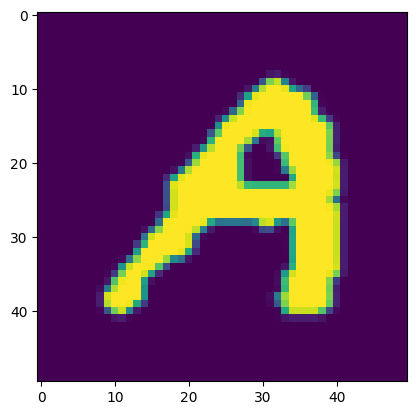

In [ ]:
plt.imshow(array_numpy_2d)

In [ ]:
conn.close()